In [12]:
import pandas as pd
import duckdb

# Path to DuckDB database
db_path = r'C:\Users\btada\Documents\financial_news.db'

# Establish a single DuckDB connection
conn = duckdb.connect(database=db_path, read_only=False)

combined_query = """
SELECT 
    a.mapped_trading_date AS publish_date, 
    a.ticker, 
    a.article_title, 
    a.description, 
    dpm.price_change_percentage,
    md.price, 
    md.volume
FROM Headlines.Articles_Trading_Day a
JOIN Headlines.Daily_Price_Movement dpm 
    ON a.mapped_trading_date = dpm.trading_date 
    AND a.ticker = dpm.ticker
JOIN Headlines.Market_Data_Daily_Processing md
    ON dpm.trading_date = md.trading_day_date 
    AND dpm.ticker = md.ticker
JOIN Headlines.Trading_Calendar tc 
    ON md.trading_day_date = tc.trading_date;
"""

news_data = conn.execute(combined_query).fetchdf()

# Close connection
conn.close()


In [32]:
# Path to DuckDB database
db_path = r'C:\Users\btada\Documents\financial_news.db'
conn = duckdb.connect(database=db_path, read_only=False)

# Query to fetch combined news, market data, and sentiment analysis
combined_query = """
SELECT 
    a.mapped_trading_date AS publish_date, 
    a.ticker, 
    a.article_title, 
    a.description, 
    dpm.price_change_percentage,
    md.price, 
    md.volume,
    f.finbert_title_label,
    f.finbert_title_score,
    f.finbert_title_positive,
    f.finbert_title_neutral,
    f.finbert_title_negative,
    f.finbert_description_label,
    f.finbert_description_score,
    f.finbert_description_positive,
    f.finbert_description_neutral,
    f.finbert_description_negative
FROM Headlines.Articles_Trading_Day a
JOIN Headlines.Daily_Price_Movement dpm 
    ON a.mapped_trading_date = dpm.trading_date 
    AND a.ticker = dpm.ticker
JOIN Headlines.Market_Data_Daily_Processing md
    ON dpm.trading_date = md.trading_day_date 
    AND dpm.ticker = md.ticker
JOIN Headlines.Trading_Calendar tc 
    ON md.trading_day_date = tc.trading_date
JOIN Headlines.finbert_analysis f
    ON a.guid = f.guid;
"""

# Load combined dataset
news_data = conn.execute(combined_query).fetchdf()
conn.close()

news_data.info()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 657547 entries, 0 to 657546
Data columns (total 17 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   publish_date                  657547 non-null  datetime64[us]
 1   ticker                        657547 non-null  object        
 2   article_title                 657547 non-null  object        
 3   description                   657547 non-null  object        
 4   price_change_percentage       655473 non-null  float32       
 5   price                         657414 non-null  float32       
 6   volume                        657414 non-null  float64       
 7   finbert_title_label           657547 non-null  object        
 8   finbert_title_score           657547 non-null  float32       
 9   finbert_title_positive        657547 non-null  float32       
 10  finbert_title_neutral         657547 non-null  float32       
 11  finbert_title

In [36]:
import pandas as pd
import numpy as np
from bertopic import BERTopic
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sentence_transformers import SentenceTransformer
from umap import UMAP
import duckdb

# Database connection
db_path = r'C:\Users\btada\Documents\financial_news.db'
conn = duckdb.connect(database=db_path, read_only=False)

# Query to fetch combined news, market data, and sentiment analysis
combined_query = """
SELECT 
    a.mapped_trading_date AS publish_date, 
    a.ticker, 
    a.article_title, 
    a.description, 
    dpm.price_change_percentage,
    md.price, 
    md.volume,
    f.finbert_title_label,
    f.finbert_title_score,
    f.finbert_title_positive,
    f.finbert_title_neutral,
    f.finbert_title_negative,
    f.finbert_description_label,
    f.finbert_description_score,
    f.finbert_description_positive,
    f.finbert_description_neutral,
    f.finbert_description_negative
FROM Headlines.Articles_Trading_Day a
JOIN Headlines.Daily_Price_Movement dpm 
    ON a.mapped_trading_date = dpm.trading_date 
    AND a.ticker = dpm.ticker
JOIN Headlines.Market_Data_Daily_Processing md
    ON dpm.trading_date = md.trading_day_date 
    AND dpm.ticker = md.ticker
JOIN Headlines.Trading_Calendar tc 
    ON md.trading_day_date = tc.trading_date
JOIN Headlines.finbert_analysis f
    ON a.guid = f.guid;
"""

# Load combined dataset
news_data = conn.execute(combined_query).fetchdf()
conn.close()

# Apply BERTopic
texts = news_data["article_title"].fillna("") + " " + news_data["description"].fillna("")
embedding_model = SentenceTransformer("paraphrase-MiniLM-L3-v2")
bertopic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=UMAP(n_neighbors=5, min_dist=0.5, n_components=5, metric='cosine'),
    verbose=True
)
topics_full, probs_full = bertopic_model.fit_transform(texts.tolist())

news_data["topic"] = topics_full
news_data["topic_probability"] = [max(prob) if isinstance(prob, list) else 0 for prob in probs_full]

# Compute average price movement per topic
topic_movement = news_data.groupby("topic")["price_change_percentage"].mean()
topic_std_dev = news_data.groupby("topic")["price_change_percentage"].std()
news_data["topic_avg_movement"] = news_data["topic"].map(topic_movement)
news_data["topic_sensitivity"] = news_data["topic"].map(topic_std_dev)

# Compute sentiment impact
news_data["sentiment_impact"] = news_data["finbert_description_positive"] - news_data["finbert_description_negative"]

# Compute rolling market volatility
news_data["market_volatility"] = news_data.groupby("ticker")["price_change_percentage"].transform(lambda x: x.rolling(window=30, min_periods=1).std())

# Compute risk score
news_data["risk_score"] = (
    news_data["sentiment_impact"] * news_data["topic_sensitivity"]
) * news_data["market_volatility"]

# Prepare model data
features = [
    "topic_avg_movement", "topic_sensitivity", "sentiment_impact", "market_volatility",
    "finbert_title_positive", "finbert_title_negative", "finbert_description_positive", "finbert_description_negative"
]
X = news_data[features]
y = news_data["price_change_percentage"]

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Model
xgb_model = XGBRegressor(objective="reg:squarederror", n_estimators=100, learning_rate=0.1)
xgb_model.fit(X_train, y_train)

# Evaluate Model
y_pred = xgb_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MAE: {mae}, R2: {r2}")

# Save results
news_data.to_csv("news_with_risk_scores.csv", index=False)
print("Processing complete. Data saved to news_with_risk_scores.csv")


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.83k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/69.6M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2025-03-06 14:32:46,844 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/20549 [00:00<?, ?it/s]

2025-03-06 14:39:17,394 - BERTopic - Embedding - Completed ✓
2025-03-06 14:39:17,394 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-06 15:12:45,886 - BERTopic - Dimensionality - Completed ✓
2025-03-06 15:12:45,945 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-06 15:26:10,709 - BERTopic - Cluster - Completed ✓
2025-03-06 15:26:10,990 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-03-06 15:27:08,787 - BERTopic - Representation - Completed ✓


XGBoostError: [15:30:57] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\data\data.cc:514: Check failed: valid: Label contains NaN, infinity or a value too large.

In [37]:
# Ensure no NaN or infinite values in target variable
news_data = news_data.replace([np.inf, -np.inf], np.nan)  # Replace infinite values with NaN
news_data = news_data.dropna(subset=["price_change_percentage"])  # Drop rows where target is NaN

# Prepare model data
features = [
    "topic_avg_movement", "topic_sensitivity", "sentiment_impact", "market_volatility",
    "finbert_title_positive", "finbert_title_negative", "finbert_description_positive", "finbert_description_negative"
]
X = news_data[features]
y = news_data["price_change_percentage"]

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Model
xgb_model = XGBRegressor(objective="reg:squarederror", n_estimators=100, learning_rate=0.1)
xgb_model.fit(X_train, y_train)

# Evaluate Model
y_pred = xgb_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MAE: {mae}, R2: {r2}")

MAE: 1.0405694246292114, R2: 0.22925794124603271


In [38]:
# Train and Evaluate Multiple Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor

models = {
    "XGBoost": XGBRegressor(objective="reg:squarederror", n_estimators=100, learning_rate=0.1),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Neural Network": MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=500, random_state=42)
}

results = []

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append((name, mae, r2))
    print(f"{name} - MAE: {mae:.4f}, R2: {r2:.4f}")

# Print Model Performance Summary
print("Model Performance Summary:")
for name, mae, r2 in results:
    print(f"{name}: MAE = {mae:.4f}, R2 = {r2:.4f}")

Training XGBoost...
XGBoost - MAE: 1.0406, R2: 0.2293
Training Random Forest...
Random Forest - MAE: 0.9190, R2: 0.3392
Training Decision Tree...
Decision Tree - MAE: 1.2079, R2: -0.2453
Training Neural Network...


ValueError: Input X contains NaN.
MLPRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [42]:
# Ensure no NaN or infinite values in target variable
news_data = news_data.replace([np.inf, -np.inf], np.nan)  # Replace infinite values with NaN
news_data = news_data.dropna(subset=["price_change_percentage"])  # Drop rows where target is NaN

# Prepare model data
features = [
    "topic", "risk_score",
    "topic_avg_movement", "topic_sensitivity", "sentiment_impact", "market_volatility",
    "finbert_title_positive", "finbert_title_negative", "finbert_description_positive", "finbert_description_negative"
]
X = news_data[features].dropna()  # Remove rows with NaN values
y = news_data.loc[X.index, "price_change_percentage"]

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ensure both training and testing sets have the same columns
X_train = X_train[X.columns]
X_test = X_test[X.columns]

import statsmodels.api as sm
from sklearn.inspection import permutation_importance

# Train and Evaluate Multiple Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor

models = {
    "XGBoost": XGBRegressor(objective="reg:squarederror", n_estimators=100, learning_rate=0.1),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Neural Network": MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=500, random_state=42)
}

results = []

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append((name, mae, r2))
    print(f"{name} - MAE: {mae:.4f}, R2: {r2:.4f}")

# Feature Importance for Tree-Based Models
feature_importance = {}
for name, model in models.items():
    if hasattr(model, "feature_importances_"):
        feature_importance[name] = model.feature_importances_

# Print feature importance
for name, importance in feature_importance.items():
    print(f"Feature Importance for {name}:")
    for feat, imp in sorted(zip(features, importance), key=lambda x: x[1], reverse=True):
        print(f"{feat}: {imp:.4f}")

# OLS Regression for Statistical Significance
X_train_sm = sm.add_constant(X_train)  # Add constant for intercept
ols_model = sm.OLS(y_train, X_train_sm).fit()
print("OLS Regression Summary:")
print(ols_model.summary())

# Permutation Feature Importance for XGBoost
perm_importance = permutation_importance(xgb_model, X_test, y_test, n_repeats=10, random_state=42)
print("Permutation Feature Importance for XGBoost:")
for feat, imp in sorted(zip(features, perm_importance.importances_mean), key=lambda x: x[1], reverse=True):
    print(f"{feat}: {imp:.4f}")

Training XGBoost...
XGBoost - MAE: 1.0409, R2: 0.2438
Training Random Forest...
Random Forest - MAE: 0.9203, R2: 0.3328
Training Decision Tree...
Decision Tree - MAE: 1.2095, R2: -0.2744
Training Neural Network...
Neural Network - MAE: 1.0889, R2: 0.1457
Feature Importance for XGBoost:
topic_avg_movement: 0.3120
finbert_title_negative: 0.1250
topic_sensitivity: 0.1177
market_volatility: 0.1052
risk_score: 0.0993
topic: 0.0901
finbert_title_positive: 0.0535
sentiment_impact: 0.0406
finbert_description_negative: 0.0355
finbert_description_positive: 0.0212
Feature Importance for Random Forest:
market_volatility: 0.2014
topic_avg_movement: 0.1695
risk_score: 0.1526
topic_sensitivity: 0.1011
finbert_title_positive: 0.0811
finbert_title_negative: 0.0798
finbert_description_positive: 0.0698
finbert_description_negative: 0.0603
sentiment_impact: 0.0480
topic: 0.0365
Feature Importance for Decision Tree:
market_volatility: 0.1972
topic_avg_movement: 0.1644
topic_sensitivity: 0.1453
risk_score: 

ValueError: feature_names mismatch: ['topic_avg_movement', 'topic_sensitivity', 'sentiment_impact', 'market_volatility', 'finbert_title_positive', 'finbert_title_negative', 'finbert_description_positive', 'finbert_description_negative'] ['topic', 'risk_score', 'topic_avg_movement', 'topic_sensitivity', 'sentiment_impact', 'market_volatility', 'finbert_title_positive', 'finbert_title_negative', 'finbert_description_positive', 'finbert_description_negative']
training data did not have the following fields: topic, risk_score

In [53]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV


# Train/Test Split
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Ensure both training and testing sets have the same columns
X_train = X_train[X.columns]
X_test = X_test[X.columns]

import statsmodels.api as sm
from sklearn.inspection import permutation_importance

# Train and Evaluate Multiple Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

models = {
    "XGBoost": XGBRegressor(objective="reg:squarederror", n_estimators=100, learning_rate=0.1),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Neural Network": MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=500, random_state=42)
}

results = []

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append((name, mae, r2))
    print(f"{name} - MAE: {mae:.4f}, R2: {r2:.4f}")

# Feature Importance for Tree-Based Models
feature_importance = {}
for name, model in models.items():
    if hasattr(model, "feature_importances_"):
        feature_importance[name] = model.feature_importances_

# Print feature importance
for name, importance in feature_importance.items():
    print(f"Feature Importance for {name}:")
    for feat, imp in sorted(zip(features, importance), key=lambda x: x[1], reverse=True):
        print(f"{feat}: {imp:.4f}")

# OLS Regression for Statistical Significance
X_train_sm = sm.add_constant(X_train)  # Add constant for intercept
ols_model = sm.OLS(y_train, X_train_sm).fit()
print("OLS Regression Summary:")
print(ols_model.summary())

# Permutation Feature Importance for XGBoost
perm_importance = permutation_importance(models["XGBoost"], X_test, y_test, n_repeats=10, random_state=42)
print("Permutation Feature Importance for XGBoost:")
for feat, imp in sorted(zip(features, perm_importance.importances_mean), key=lambda x: x[1], reverse=True):
    print(f"{feat}: {imp:.4f}")

Training XGBoost...
XGBoost - MAE: 1.0398, R2: 0.2129
Training Random Forest...
Random Forest - MAE: 0.9266, R2: 0.3146
Training Decision Tree...
Decision Tree - MAE: 1.2056, R2: -0.0622
Training Neural Network...
Neural Network - MAE: 1.1131, R2: 0.1286
Feature Importance for XGBoost:
topic_avg_movement: 0.3716
market_volatility: 0.1216
finbert_title_positive: 0.0997
topic_sensitivity: 0.0882
sentiment_impact: 0.0715
topic: 0.0581
finbert_title_negative: 0.0541
finbert_description_negative: 0.0519
finbert_description_positive: 0.0510
risk_score: 0.0324
Feature Importance for Random Forest:
market_volatility: 0.1833
topic_avg_movement: 0.1779
risk_score: 0.1440
finbert_title_positive: 0.0883
topic_sensitivity: 0.0875
finbert_title_negative: 0.0864
finbert_description_positive: 0.0768
finbert_description_negative: 0.0635
sentiment_impact: 0.0505
topic: 0.0419
Feature Importance for Decision Tree:
topic_avg_movement: 0.1795
market_volatility: 0.1687
risk_score: 0.1466
topic_sensitivity: 

In [57]:
import pandas as pd
import numpy as np
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from umap import UMAP
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
import duckdb
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
import statsmodels.api as sm
from sklearn.inspection import permutation_importance
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Compute average price movement per topic
topic_movement = news_data.groupby("topic")["price_change_percentage"].mean()
topic_std_dev = news_data.groupby("topic")["price_change_percentage"].std()
news_data["topic_avg_movement"] = news_data["topic"].map(topic_movement)
news_data["topic_sensitivity"] = news_data["topic"].map(topic_std_dev)

# Compute sentiment impact
news_data["sentiment_impact"] = news_data["finbert_description_positive"] - news_data["finbert_description_negative"]

# Compute rolling market volatility
news_data["market_volatility"] = news_data.groupby("ticker")["price_change_percentage"].transform(lambda x: x.rolling(window=30, min_periods=1).std())

# Compute risk score
news_data["risk_score"] = (
    news_data["sentiment_impact"] * news_data["topic_sensitivity"]
) * news_data["market_volatility"]

# Log-transform selected features
news_data["topic_avg_movement_log"] = np.log1p(news_data["topic_avg_movement"])
news_data["market_volatility_log"] = np.log1p(news_data["market_volatility"])
news_data["risk_score_log"] = np.log1p(news_data["risk_score"])

# Ensure no NaN or infinite values in target variable
news_data = news_data.replace([np.inf, -np.inf], np.nan)  # Replace infinite values with NaN
news_data = news_data.dropna(subset=["price_change_percentage"])  # Drop rows where target is NaN

# Prepare model data
features = [
    "topic", "risk_score_log", "topic_avg_movement_log", "topic_sensitivity", "sentiment_impact", "market_volatility_log",
    "finbert_title_positive", "finbert_title_negative", "finbert_description_positive", "finbert_description_negative"
]
X = news_data[features].dropna()
y = news_data.loc[X.index, "price_change_percentage"]

# Train/Test Split with K-Fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

X_train_vif = sm.add_constant(X_train)

# Compute VIF for all features, including the constant term
vif_values = [variance_inflation_factor(X_train_vif.values, i) for i in range(X_train_vif.shape[1])]

# Create DataFrame and exclude the constant term from printing
vif_data = pd.DataFrame({
    "Feature": ["const"] + X_train.columns.tolist(),
    "VIF": vif_values
})
print("Variance Inflation Factors:")
print(vif_data[vif_data["Feature"] != "const"])  # Exclude constant from the final printout


# Train Multiple Models
models = {
    "XGBoost": XGBRegressor(objective="reg:squarederror", n_estimators=100, learning_rate=0.1),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Neural Network": MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=500, random_state=42)
}

# Stacking Model
stacking_model = StackingRegressor(
    estimators=[("rf", models["Random Forest"]), ("xgb", models["XGBoost"])], final_estimator=XGBRegressor()
)
models["Stacking Model"] = stacking_model

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"{name} - MAE: {mean_absolute_error(y_test, y_pred):.4f}, R2: {r2_score(y_test, y_pred):.4f}")

c:\Users\btada\Documents\OMSAPracticum\new_env\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning:

divide by zero encountered in log1p

c:\Users\btada\Documents\OMSAPracticum\new_env\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning:

invalid value encountered in log1p



Variance Inflation Factors:
                         Feature           VIF
1                          topic  1.046440e+00
2                 risk_score_log  2.241190e+00
3         topic_avg_movement_log  1.013872e+00
4              topic_sensitivity  1.245465e+00
5               sentiment_impact  3.002400e+15
6          market_volatility_log  1.144734e+00
7         finbert_title_positive  1.350780e+00
8         finbert_title_negative  1.282310e+00
9   finbert_description_positive  1.125900e+15
10  finbert_description_negative  1.286743e+15
Training XGBoost...
XGBoost - MAE: 0.8576, R2: 0.1679
Training Random Forest...
Random Forest - MAE: 0.7461, R2: 0.3663
Training Decision Tree...
Decision Tree - MAE: 0.9654, R2: 0.0242
Training Neural Network...
Neural Network - MAE: 0.8991, R2: 0.0881
Training Stacking Model...
Stacking Model - MAE: 0.8432, R2: 0.3787


Training XGBoost...
XGBoost - MAE: 0.8731, R2: 0.0707
Training Random Forest...
Random Forest - MAE: 0.8245, R2: 0.0274
Training Decision Tree...
Decision Tree - MAE: 1.0298, R2: -0.6017
Training Neural Network...
Neural Network - MAE: 0.8956, R2: 0.0404
Training Stacking Model...
Stacking Model - MAE: 0.8726, R2: 0.0422


100%|===================| 80456/80527 [02:29<00:00]        

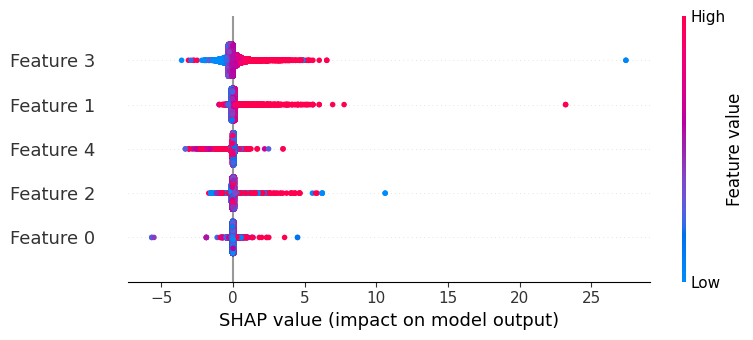

In [59]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
import shap

# Drop high-VIF features
news_data.drop(columns=["sentiment_impact"], inplace=True, errors='ignore')

# Ensure no NaN or infinite values in target variable
news_data = news_data.replace([np.inf, -np.inf], np.nan)  # Replace infinite values with NaN
news_data = news_data.dropna(subset=["price_change_percentage"])  # Drop rows where target is NaN

# Prepare model data
features = [
    "topic", "risk_score_log", "topic_avg_movement_log", "topic_sensitivity", "market_volatility_log",
    "finbert_title_positive", "finbert_title_negative"
]
X = news_data[features].dropna()
y = news_data.loc[X.index, "price_change_percentage"]

# Apply PCA to reduce dimensionality
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X)

# Train/Test Split with K-Fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for train_index, test_index in kf.split(X_pca):
    X_train, X_test = X_pca[train_index], X_pca[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Train Multiple Models
models = {
    "XGBoost": XGBRegressor(objective="reg:squarederror", n_estimators=100, learning_rate=0.1),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Neural Network": MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=500, random_state=42)
}

# Stacking Model
stacking_model = StackingRegressor(
    estimators=[("rf", models["Random Forest"]), ("xgb", models["XGBoost"])], final_estimator=XGBRegressor()
)
models["Stacking Model"] = stacking_model

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"{name} - MAE: {mean_absolute_error(y_test, y_pred):.4f}, R2: {r2_score(y_test, y_pred):.4f}")

# Compute SHAP Values for Feature Importance
explainer = shap.Explainer(models["XGBoost"], X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

In [60]:
from sklearn.feature_selection import SelectKBest, f_regression


# Ensure no NaN or infinite values in target variable
news_data = news_data.replace([np.inf, -np.inf], np.nan)  # Replace infinite values with NaN
news_data = news_data.dropna(subset=["price_change_percentage"])  # Drop rows where target is NaN

# Prepare model data
features = [
    "topic", "risk_score_log", "topic_avg_movement_log", "topic_sensitivity", "market_volatility_log",
    "finbert_title_positive", "finbert_title_negative"
]
X = news_data[features].dropna()
y = news_data.loc[X.index, "price_change_percentage"]

# Feature Selection
selector = SelectKBest(score_func=f_regression, k=5)
X_selected = selector.fit_transform(X, y)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Hyperparameter Tuning for XGBoost
xgb_params = {
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.2],
    "n_estimators": [100, 200]
}

grid_xgb = GridSearchCV(XGBRegressor(objective="reg:squarederror"), xgb_params, cv=5, scoring="r2")
grid_xgb.fit(X_train, y_train)
print(f"Best XGBoost Params: {grid_xgb.best_params_}")

# Hyperparameter Tuning for Random Forest
rf_params = {
    "n_estimators": [100, 200],
    "max_features": ["sqrt", "log2"]
}

grid_rf = GridSearchCV(RandomForestRegressor(random_state=42), rf_params, cv=5, scoring="r2")
grid_rf.fit(X_train, y_train)
print(f"Best Random Forest Params: {grid_rf.best_params_}")

# Train Multiple Models
models = {
    "XGBoost": grid_xgb.best_estimator_,
    "Random Forest": grid_rf.best_estimator_,
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Neural Network": MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=500, random_state=42)
}

# Stacking Model
stacking_model = StackingRegressor(
    estimators=[("rf", models["Random Forest"]), ("xgb", models["XGBoost"])], final_estimator=XGBRegressor()
)
models["Stacking Model"] = stacking_model

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"{name} - MAE: {mean_absolute_error(y_test, y_pred):.4f}, R2: {r2_score(y_test, y_pred):.4f}")


Best XGBoost Params: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}
Best Random Forest Params: {'max_features': 'sqrt', 'n_estimators': 200}
Training XGBoost...
XGBoost - MAE: 0.8707, R2: 0.1359
Training Random Forest...
Random Forest - MAE: 0.8356, R2: 0.1555
Training Decision Tree...
Decision Tree - MAE: 1.0813, R2: -0.4901
Training Neural Network...
Neural Network - MAE: 0.9345, R2: 0.0039
Training Stacking Model...
Stacking Model - MAE: 0.8224, R2: 0.1608


In [61]:
print("\n📊 Price Change Percentiles:")
print(news_data["price_change_percentage"].quantile([0.01, 0.05, 0.95, 0.99]))


📊 Price Change Percentiles:
0.01   -5.96
0.05   -2.69
0.95    2.92
0.99    6.19
Name: price_change_percentage, dtype: float64
